### Data Preprocessing and Visualizations

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv(r"C:\Users\akars\Downloads\Reviews.csv")

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.shape

(568454, 10)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


###### The dataset has around 5.6k reviews with scores ranging from 1 to 5. Lets prepare our data.

In [6]:
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#### Objective of the project is  NLP classification and Sentiment Analysis prediction, Hence its best to work with the actual textual data that matters and its scores.

In [7]:
data1 = data[['Text','Score']].dropna()
ax=data1.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()

In [8]:
data1.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [9]:
# remove duplicates/ for every duplicate we will keep only one row of that type. 
data1.drop_duplicates(subset=['Text','Score'],keep='first',inplace=True) 

In [10]:
data1.shape # we see a drop of 568454 entries

(393675, 2)

#### Lets categorize all scores less than and equal to 3 as negative and the others positive.

In [11]:
data1.Score[data1.Score<=3]=0
data1.Score[data1.Score>=4]=1

In [12]:
data1.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


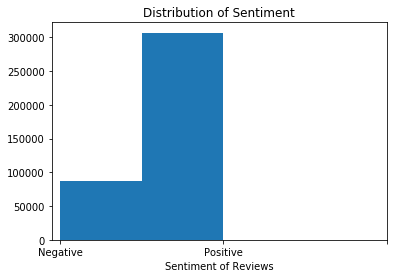

In [13]:
import matplotlib.pyplot as plt
plt.hist(data1.Score, bins = 2, align= 'mid')
plt.xticks(range(3), ['Negative', 'Positive'])
plt.xlabel('Sentiment of Reviews')
plt.title('Distribution of Sentiment')
plt.show()

In [14]:
print(data1['Score'].value_counts(normalize=True)) # Negative reviews contributing close to 22% of text data

1    0.779371
0    0.220629
Name: Score, dtype: float64


In [15]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

clean = lambda x: clean_text(x)
data1['Text'] = data1.Text.apply(clean)


In [16]:
data1

,Text,Score
0,i have bought several of the vitality canned d...,1
1,product arrived labeled as jumbo salted peanut...,0
2,this is a confection that has been around a fe...,1
3,if you are looking for the secret ingredient i...,0
4,great taffy at a great price there was a wide...,1
...,...,...
568449,great for sesame chickenthis is a good if not ...,1
568450,im disappointed with the flavor the chocolate ...,0
568451,these stars are small so you can give of thos...,1
568452,these are the best treats for training and rew...,1


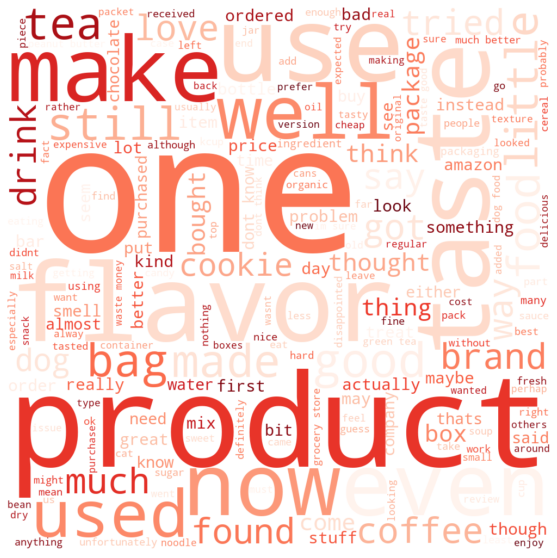

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Polarity == 0 negative
train_s0 = data1[data1.Score ==0]
all_text = " ".join(word for word in train_s0.Text)
wordcloud = WordCloud(colormap="Reds", width=1000, height=1000, mode="RGBA", background_color="white").generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

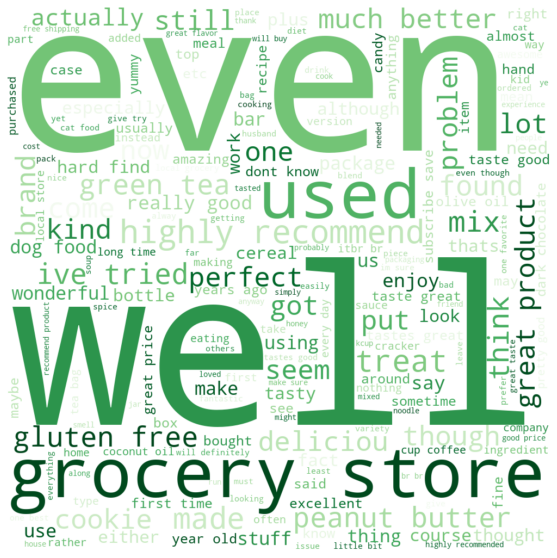

In [18]:
# Polarity == 1 positive
train_s1 = data1[data1.Score ==1]
all_text = " ".join(word for word in train_s1.Text)
wordcloud = WordCloud(colormap="Greens", width=1000, height=1000, mode="RGBA", background_color="white").generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### In the negative sentiments the biggest highlighted terms are "thought","make","use" and a lot of medium sized words that seems to be important including "cookie","bad","used","problem","found","tried", "one" etc. 
#### The positive sentiments  have their biggest highlighted terms as "grocery","store", "better","gluten","coffee","cup","green tea", "cat","dog","food"etc.


#### Not many details are clear at this stage. We can see the grocery or stores are particularly positive apart from gluten free products or cat food ,green tea etc.  Negative sentiments seems to come from mostly trying out products and the only product particularly highlighted are cookies and dog food. There are words like "great ", "delicious" etc that comes in negative sentiments as well.  This suggests that hyperparamter tuning is needed to truly predict its sentiment.


In [19]:
# Split the data into Train and Test Sets
X = data1['Text']
y = data1['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.2, random_state=42)


In [20]:
from sklearn.dummy import DummyClassifier
dm= DummyClassifier()
print('# train records: {}'.format(X_train.shape[0]))
print('# test records: {}'.format(X_test.shape[0]))
clf = dm.fit(X_train, y_train)
acc = clf.score(X_test,y_test)
print ('Base Model Accuracy: {}'.format(acc))

# train records: 314940
# test records: 78735
Base Model Accuracy: 0.6539277322664635


### Score Predictions

#### The basic data extraction , cleaning and the train/test splitting has been done. Before we go into data modelling, it is necessary for texts to be in a numerical format. We use vectorizers for it plus n-gramsof range 1,3 which further helps by going in detail in terms of characters and not just words.
#### 1) TF-IDF (term frequency–inverse document frequency) vectorises words by checking the frequency of words in a collection or document. to make better probability of a prediction or occurences of certain words after words.
#### 2) Count Vectorizer works like a word tokenizer with each of them as a feature. 

#### We use both a simple logisitics regression and Naive bayes classifier algorithms comparing scores and log losses.


In [24]:
# creating the logloss function
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [25]:

tfv = TfidfVectorizer(min_df=3,  max_features=100000, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_test))
xtrain_tfv =  tfv.transform(X_train) 
xtest_tfv = tfv.transform(X_test)

In [41]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, y_train)
predictions = dict()
predictionscores = dict()
predictions['TF-IDF|Log Reg'] = clf.predict_proba(xtest_tfv)
predictionscores['TF-IDF|Log Reg'] = clf.predict(xtest_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions['TF-IDF|Log Reg']))
print ("accuracy: %0.3f " % clf.score(xtest_tfv, y_test))


logloss: 0.253 
accuracy: 0.897 


In [27]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, y_train)
predictions['TF-IDF|NaiveBayes'] = clf.predict_proba(xtest_tfv)
predictionscores['TF-IDF|NaiveBayes'] = clf.predict(xtest_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions['TF-IDF|NaiveBayes']))
print ("accuracy: %0.3f " % clf.score(xtest_tfv, y_test))

logloss: 0.297 
accuracy: 0.869 


#### Seems the TF-IDF model gives us a pretty good log loss value of 0.253 for logistics regression. Lets try another model , this time using word count as a feature based on count-vectorizer.

In [28]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english',max_features=100000)

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X_train) + list(X_test))
xtrain_ctv =  ctv.transform(X_train) 
xtest_ctv = ctv.transform(X_test)

In [29]:
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, y_train)
predictions['CountVectorizer|Log Reg'] = clf.predict_proba(xtest_ctv)
predictionscores['CountVectorizer|Log Reg'] = clf.predict(xtest_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions['CountVectorizer|Log Reg']))
print ("accuracy: %0.3f " % clf.score(xtest_ctv, y_test))

logloss: 0.318 
accuracy: 0.890 


In [30]:
clf = MultinomialNB()
clf.fit(xtrain_ctv, y_train)
predictions['CountVectorizer|NaiveBayes'] = clf.predict_proba(xtest_ctv)
predictionscores['CountVectorizer|NaiveBayes'] = clf.predict(xtest_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions['CountVectorizer|NaiveBayes']))
print ("accuracy: %0.3f " % clf.score(xtest_ctv, y_test))

logloss: 0.784 
accuracy: 0.872 


#### Count vectorizer+ngrams gave us a logloss of 0.318 with an accuracy of 0.89. We could ultimately go with TF-IDF+ngrams considering a better logloss value which is 0.256 and an accuracy of 0.897. The baseline accuracy for the model was 0.65 and looks like we have got a much better score with our selected model.

### Hyperparameter Tuning

#### Lets try Hyperparameter tuning of TF-IDF \ Logisitics Regression by adding Gridsearch CV to improve the accuracy .

In [37]:
lr_params = {'penalty': ['l1','l2'],
          'solver':['liblinear'],
          'C': np.logspace(-10,10,21)}
lr = LogisticRegression(C=1.0)
# Define the gridsearchCV
lr_grid = GridSearchCV(lr, param_grid=lr_params, cv=3, n_jobs=-1, verbose=1)

# fit with the tranformed sparse matrix
lr_grid.fit(xtrain_tfv, y_train)
predictions['TF-IDF|Logreg GridsearchCV'] = clf.predict_proba(xtest_tfv)
predictionscores['TF-IDF|Logreg GridsearchCV'] = clf.predict(xtest_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions['TF-IDF|Logreg GridsearchCV']))
print ("accuracy: %0.3f " % clf.score(xtest_tfv, y_test))

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed: 15.0min finished


logloss: 0.254 
accuracy: 0.896 


#### Looks like hyperparameter tuning did not do so much of a difference in terms of accuracy. Lets plot the AUC so far from our models

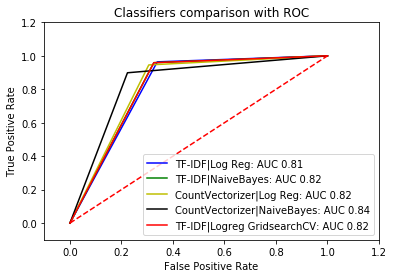

In [39]:
colors = ['b', 'g', 'y', 'k','r']
cmp=0
from sklearn.metrics import roc_curve, auc
for model, predicted in predictionscores.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Looks like the best model performance was TF-IDF + ngrams under Logistics regression algorithm with a log loss of 0.253, accuracy of 0.89 and an AUC of 0.81. Hence this model is our choice.


#### Taking a look at the top words both positive & negative as well as its coefficients from the model. 

In [109]:
clf = LogisticRegression(C=1.0)
c = clf.fit(xtrain_tfv, y_train)
words = tfv.get_feature_names()
coef = c.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : words, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(coeff_df.tail(20).to_string(index=False))


-Top 20 positive-
              Word  Coefficient
             great    12.558525
         delicious    12.332668
              best    11.802054
           perfect    10.926785
         excellent     9.840667
             loves     9.175749
              love     8.794433
         wonderful     8.760023
           amazing     7.889328
  highly recommend     7.447267
        just right     7.360043
 wont disappointed     7.264369
           pleased     7.226629
           awesome     7.214606
            highly     7.060426
             yummy     6.763398
            hooked     6.754314
          favorite     6.302973
              glad     6.265446
         fantastic     5.877539

-Top 20 negative-
           Word  Coefficient
       wont buy    -5.488047
            bad    -5.774204
     disgusting    -5.786144
           weak    -6.558609
          threw    -6.650997
         hoping    -6.734087
          stale    -6.762776
         return    -6.832639
    wont buying    -6.905443


### word results

In [73]:
print(metrics.classification_report(y_test, predictionscores['TF-IDF|Log Reg'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.84      0.66      0.74     17371
    negative       0.91      0.96      0.94     61364

    accuracy                           0.90     78735
   macro avg       0.87      0.81      0.84     78735
weighted avg       0.89      0.90      0.89     78735



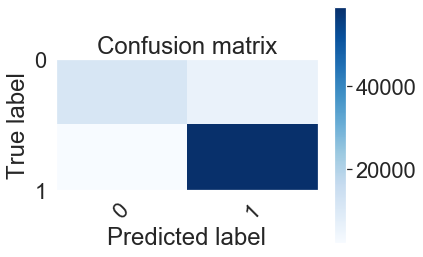

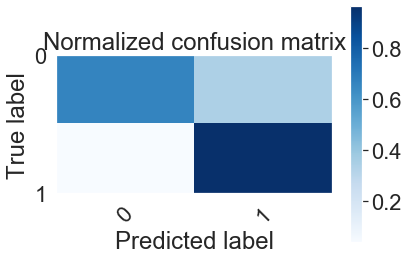

0 Sentiments Detected (True Negatives): 0.661 
0 Sentiments Incorrectly Detected (False Positives): 0.339 
1 Sentiments Missed (False Negatives): 0.036 
1 Sentiment Detected (True Positives): 0.964 
Total Sentiments predicted as positive:  61364
accuracy is: 0.897 


In [86]:
from sklearn.metrics import accuracy_score, classification_report

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(y)))
    plt.xticks(tick_marks, set(y), rotation=45)
    plt.yticks(tick_marks, set(y))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test,  predictionscores['TF-IDF|Log Reg'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    
plt.grid(False)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.grid(False)
plt.show()

print('0 Sentiments Detected (True Negatives): %0.3f '% cm_normalized[0][0])
print('0 Sentiments Incorrectly Detected (False Positives): %0.3f '%cm_normalized[0][1])
print('1 Sentiments Missed (False Negatives): %0.3f '% cm_normalized[1][0])
print('1 Sentiment Detected (True Positives): %0.3f '% cm_normalized[1][1])
print('Total Sentiments predicted as positive: ', np.sum(cm[1]))
print('accuracy is: %0.3f '% accuracy_score(predictionscores['TF-IDF|Log Reg'],y_test))


In [87]:
data['Helpful %'] = np.where(data['HelpfulnessDenominator'] > 0,data['HelpfulnessNumerator'] / data['HelpfulnessDenominator'], -1)
data['% Upvote'] = pd.cut(data['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty
